In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# What each step does:

# first grabs data from heart.csv.

# It separates this list into two groups: one with all the details about each person's health and another that says if they have heart disease or not.

# It then splits these groups into smaller groups for training and testing the computer.

# Teaches computer how to use health info to guess if someone has heart disease or not.

# Once the computer learns, it tries to guess if people in the test group have heart disease based on their health info.

# Last, it checks how well the computer did by plotting a graph.

In [45]:
data = pd.read_csv("heart.csv")

X = data.drop('output', axis=1)
y = data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_scores = gnb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# This part of the code evaluates the performance of the GNB model.
# The accuracy score tells us how well the model is able to correctly predict whether or not a person has heart disease based on their health information.

In [46]:
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8688524590163934


# Visual representation of how well the model is distinguishing between positive and negative cases by plotting the ROC curve.

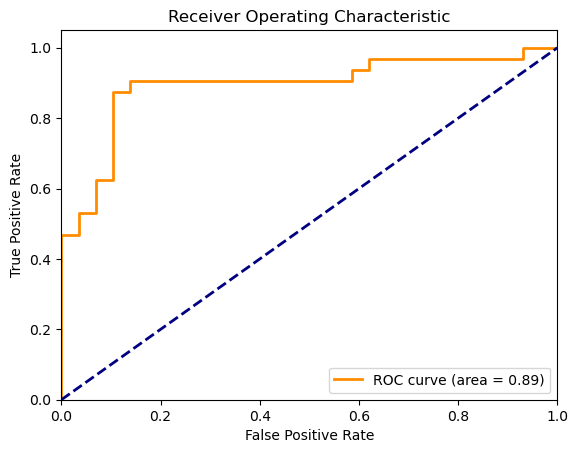

In [47]:
# ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# A heatmap representation of the confusion matrix.

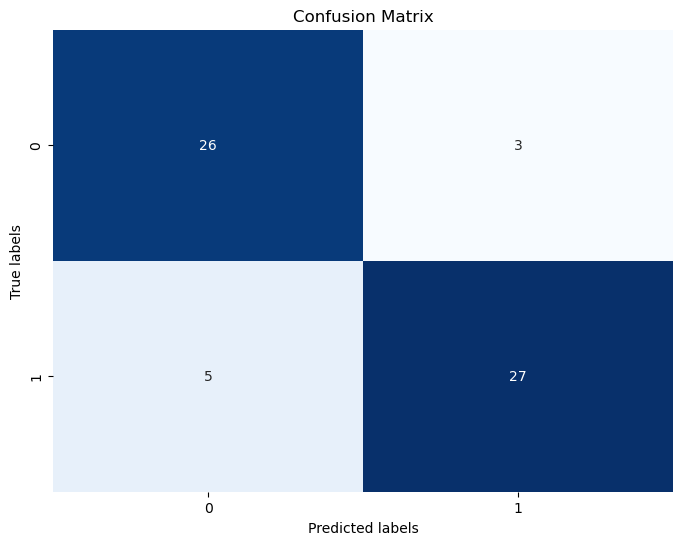

In [48]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# This graph gives insights into how well the model is identifying positive cases.

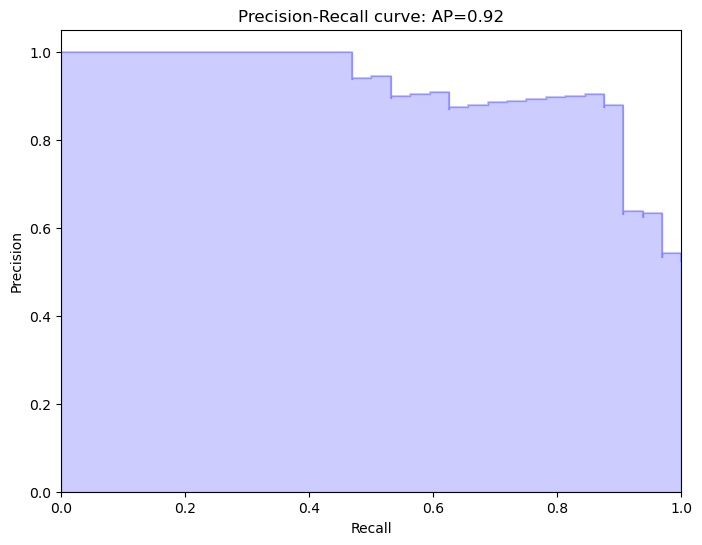

In [49]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

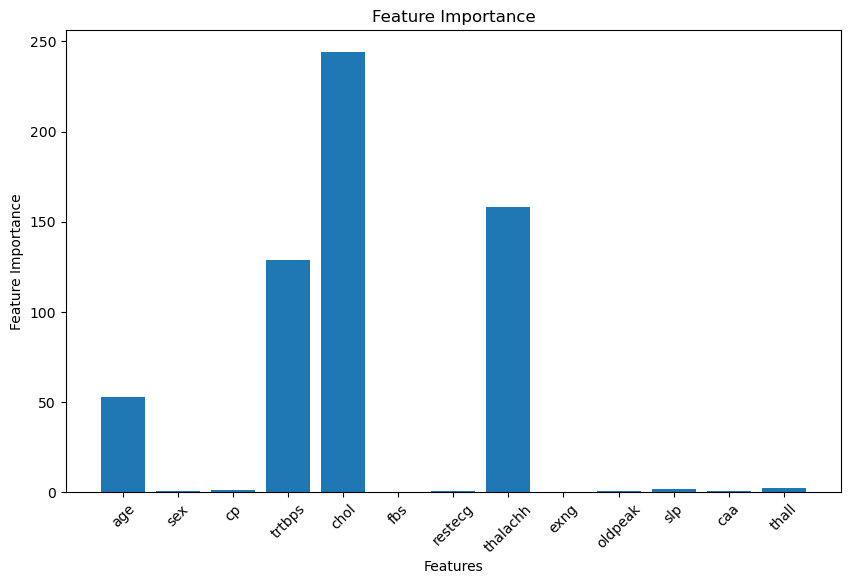

In [50]:
# Feature Importance
feature_importance = gnb.theta_[1]  # Using mean of the Gaussian distribution as feature importance
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

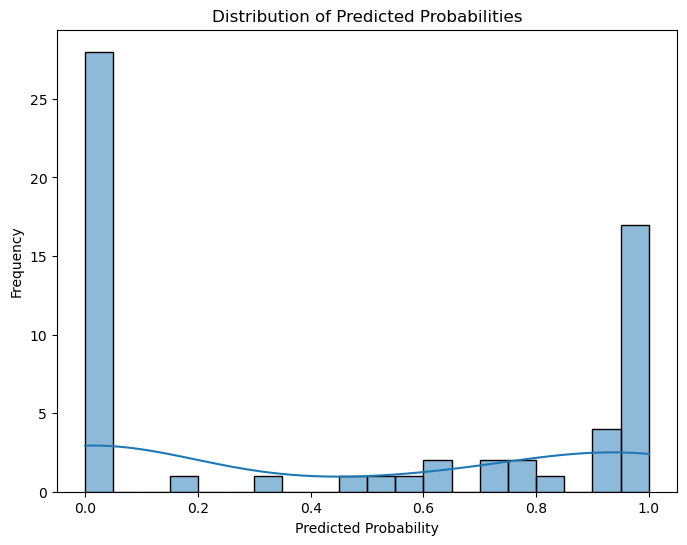

In [51]:
# Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_scores, bins=20, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

In [55]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

df = pd.read_csv('heart.csv')
X = df.drop('output', axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', GaussianNB()) 
])

param_grid = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='recall')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import recall_score
test_recall = recall_score(y_test, y_pred)
print("Recall on Test Set:", test_recall)


Best Parameters: {'model__var_smoothing': 1e-09}
Best Recall Score: 0.8190883190883189
Recall on Test Set: 0.84375


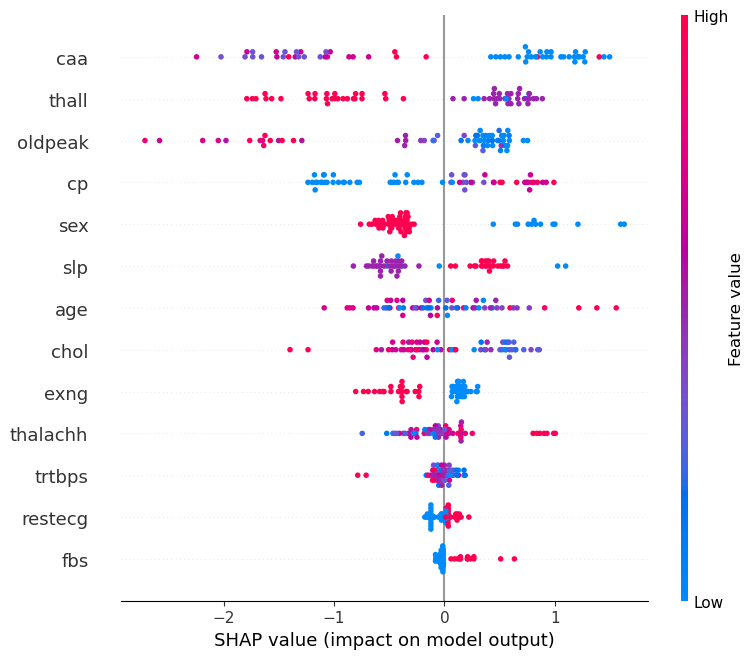

In [56]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

data = pd.read_csv("heart.csv")

X = data.drop('output', axis=1)
y = data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

surrogate_model = GradientBoostingClassifier(random_state=42)
surrogate_model.fit(X_train, y_train)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_proba = gnb.predict_proba(X_test)

explainer = shap.Explainer(surrogate_model, X_train)
shap_values = explainer.shap_values(X_test, gnb_proba, check_additivity=False)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
